# Notebook for testing and exploring the generalized workflow for feature extraction

In [1]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper

from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.feature_selection import SelectKBest, chi2
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC

figure_path = module_path + '/figures/'

# Loading already extracted features

In [36]:
X, y = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/UiTdataset_simple_split_2.ts')

X = from_nested_to_2d_array(X)

X.columns = np.arange(len(X.columns))

y = pd.Series(y)

kwargs = dict(test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)


kwargs = dict(test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, **kwargs)


scaler = MinMaxScaler() 
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train)) 
X_val = pd.DataFrame(scaler.transform(X_val)) 
X_test = pd.DataFrame(scaler.transform(X_test)) 

In [26]:
y_train.value_counts()

wheeze     3441
normal     3249
crackle    2202
dtype: int64

### Plotting PCR

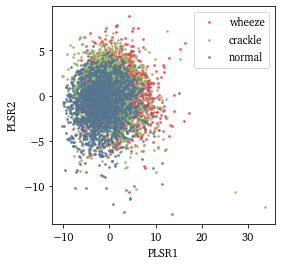

In [38]:
y_train_f = pd.factorize(y_train)[0]

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train, y_train_f)
f, ax = helper.scatterplot_with_colors(p2[0], y_train_f,
                                       module_path, new_legends = ['wheeze', 'crackle', 'normal'],
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

#f.savefig(figure_path + f'PLSR_preproject_lung.pdf', bbox_inches='tight')

### Plotting the performance

Here a Gaussian Process classifier is utilized. This works well because we want a problibalistic classifier

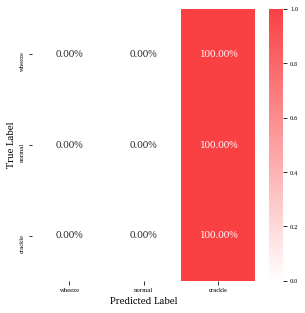

In [17]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 10)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0, n_jobs = -3)
gpc.fit(X_train,y_train)
pred = gpc.predict(X_test)

f, ax = utility.plot_cm(y_test, pred, module_path = module_path, class_names = list(y_train.value_counts().index))

plt.show()

#f.savefig(figure_path + f'lung_minirocket_cm.pdf', bbox_inches='tight')

In [5]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
k_range = list(range(1,8))

weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)


search = GridSearchCV(SVC(class_weight = 'balanced'), tuned_parameters, cv=5)
search.fit(X_train, y_train)

clf = search.best_estimator_
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = list(y_train.value_counts().index))


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

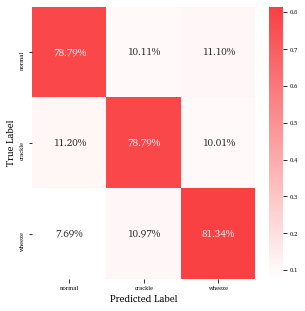

In [39]:
#clf = GaussianNB().fit(X_train.iloc[indices_train], y_train.iloc[indices_train])
clf = KNeighborsClassifier(n_neighbors=4, weights='distance').fit(X_train , y_train)
 
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = list(y_test.value_counts().index))


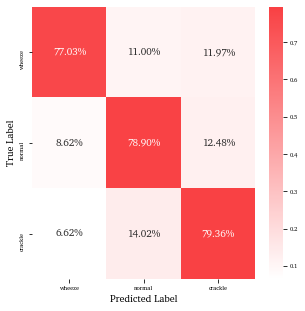

In [29]:
#clf = GaussianNB().fit(X_train.iloc[indices_train], y_train.iloc[indices_train])
clf = KNeighborsClassifier(n_neighbors=4, weights='distance').fit(X_train , y_train)
 
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = list(y_test.value_counts().index))


# Two class problem

In [42]:
indices_0 = np.where(y_train == 'normal')[0]
indices_1 = np.where(y_train == 'crackle')[0]
indices_train = np.concatenate((indices_0, indices_1))

indices_0 = np.where(y_test == 'normal')[0]
indices_1 = np.where(y_test == 'crackle')[0]
indices_test = np.concatenate((indices_0, indices_1))

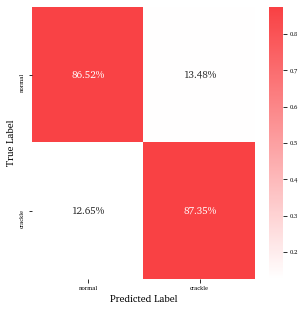

In [43]:
#clf = GaussianNB().fit(X_train.iloc[indices_train], y_train.iloc[indices_train])
clf = KNeighborsClassifier(n_neighbors=4, weights='distance').fit(X_train.iloc[indices_train], y_train.iloc[indices_train])
 
y_pred = clf.predict(X_test.iloc[indices_test])

f, ax = utility.plot_cm(y_test.iloc[indices_test], y_pred, module_path = module_path, class_names = list(y_test.iloc[indices_test].value_counts().index))


In [23]:
y_train.value_counts()

wheeze     646
normal     599
crackle    414
dtype: int64